In [1]:
from __future__ import print_function, division
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

# location to save figures
import os
cwd = os.getcwd()
figure_path = cwd + '/figures/'

# Subhalo Anisotropy Effects

In [2]:
# load a test halo catalog

from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar',
                            redshift=0.0, dz_tol=0.001, version_name='halotools_v0p4')
#halocat = CachedHaloCatalog(simname='multidark', halo_finder='rockstar',
#                            redshift=0.4660, dz_tol=0.001, version_name='halotools_v0p4')

## Build Models

In [3]:
from intrinsic_alignments.ia_models.ia_model_components import CentralAlignment
from intrinsic_alignments.ia_models.ia_model_components import RadialSatelliteAlignment
from intrinsic_alignments.ia_models.occupation_models import SubHaloPositions, IsotropicSubhaloPositions, SemiIsotropicSubhaloPositions

In [4]:
# define subhalo positions
satellite_position_model_1 = SubHaloPositions()
satellite_position_model_2 = IsotropicSubhaloPositions(Lbox=halocat.Lbox)
satellite_position_model_3 = SemiIsotropicSubhaloPositions(Lbox=halocat.Lbox)

table_1 = Table(np.copy(halocat.halo_table))
table_1 = satellite_position_model_1.assign_gal_type(table=table_1)
table_1 = satellite_position_model_1.assign_positions(table=table_1)

table_2 = Table(np.copy(halocat.halo_table))
table_2 = satellite_position_model_2.assign_gal_type(table=table_2)
table_2 = satellite_position_model_2.assign_positions(table=table_2)

table_3 = Table(np.copy(halocat.halo_table))
table_3 = satellite_position_model_3.assign_gal_type(table=table_3)
table_3 = satellite_position_model_3.assign_positions(table=table_3)

In [5]:
# define subhalo and host halo alignments
satellite_alignment_model = RadialSatelliteAlignment(satellite_alignment_strength=0.85, Lbox=halocat.Lbox)
central_alignment_model = CentralAlignment(central_alignment_strength=0.99)

table_1 = central_alignment_model.assign_central_orientation(table=table_1)
table_1 = satellite_alignment_model.assign_satellite_orientation(table=table_1)

table_2 = central_alignment_model.assign_central_orientation(table=table_2)
table_2 = satellite_alignment_model.assign_satellite_orientation(table=table_2)

table_3 = central_alignment_model.assign_central_orientation(table=table_3)
table_3 = satellite_alignment_model.assign_satellite_orientation(table=table_3)

/Users/duncan/Projects/intrinsic_alignments/ia_models/ia_model_components.py:187: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)
/Users/duncan/Projects/intrinsic_alignments/ia_models/ia_model_components.py:420: UserWarning: 1033565 galaxies have a radial distance equal to zero (or infinity) from their host. These galaxies will be re-assigned random alignment vectors.
  warn(msg)
/Users/duncan/Projects/intrinsic_alignments/ia_models/ia_model_components.py:428: UserWarning: `satellite_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)


In [6]:
# examine galaxy-galaxy correlation function
from halotools.mock_observables import tpcf

rbins = np.logspace(-1,1.2,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

mask_0 = (halocat.halo_table['halo_mpeak']>10**12.5)
mask_1 = (table_1['halo_mpeak']>10**12.5)
mask_2 = (table_2['halo_mpeak']>10**12.5)
mask_3 = (table_3['halo_mpeak']>10**12.5)

coords_0 = np.vstack((halocat.halo_table['halo_x'],
                      halocat.halo_table['halo_y'],
                      halocat.halo_table['halo_z'])).T
result_0 = tpcf(coords_0[mask_0], rbins=rbins, period=halocat.Lbox)

coords_1 = np.vstack((table_1['x'],table_1['y'],table_1['z'])).T
result_1 = tpcf(coords_1[mask_1], rbins=rbins, period=halocat.Lbox, num_threads=4)

coords_2 = np.vstack((table_2['x'],table_2['y'],table_2['z'])).T
result_2 = tpcf(coords_2[mask_2], rbins=rbins, period=halocat.Lbox, num_threads=4)

coords_3 = np.vstack((table_3['x'],table_3['y'],table_3['z'])).T
result_3 = tpcf(coords_3[mask_3], rbins=rbins, period=halocat.Lbox, num_threads=4)

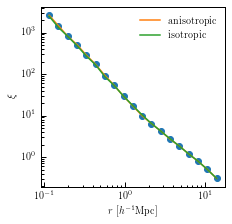

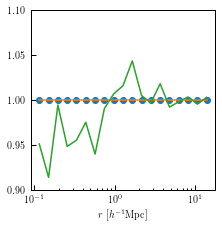

In [7]:
fig = plt.figure(figsize=(3.3,3.3))
l1, = plt.plot(rbin_centers, result_0, 'o')
l1, = plt.plot(rbin_centers, result_1)
l2, = plt.plot(rbin_centers, result_2)
#l2, = plt.plot(rbin_centers, result_3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
plt.ylabel(r'$\xi$')
plt.legend([l1,l2],['anisotropic','isotropic'], loc='upper right', frameon=False)
plt.show()

fig.savefig('/Users/duncan/Desktop/xi_anisotropy.pdf', dpi=250)

fig = plt.figure(figsize=(3.3,3.3))
l1, = plt.plot(rbin_centers, result_0/result_0, 'o')
l1, = plt.plot(rbin_centers, result_1/result_0)
l2, = plt.plot(rbin_centers, result_2/result_0)
#l2, = plt.plot(rbin_centers, result_3/result_0)
plt.xscale('log')
plt.xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
plt.ylim([0.9,1.1])
plt.show()

fig.savefig('/Users/duncan/Desktop/xi_anisotropy_diff.pdf', dpi=250)

In [8]:
from halotools.mock_observables.alignments import ed_3d, ee_3d

orientations_0 = np.vstack((halocat.halo_table['halo_axisA_x'],
                            halocat.halo_table['halo_axisA_y'],
                            halocat.halo_table['halo_axisA_z'])).T
mask = (np.prod(orientations_0*orientations_0,axis=-1)==0)
print(np.sum(mask))
orientations_0[mask,:] = np.random.random(3)

orientations_1 = np.vstack((table_1['galaxy_axisA_x'],
                            table_1['galaxy_axisA_y'],
                            table_1['galaxy_axisA_z'])).T
mask = (np.prod(orientations_1*orientations_1,axis=-1)==0)
print(np.sum(mask))
#orientations_1[mask,:] = np.random.random(3)

orientations_2 = np.vstack((table_2['galaxy_axisA_x'],
                            table_2['galaxy_axisA_y'],
                            table_2['galaxy_axisA_z'])).T
mask = (np.prod(orientations_2*orientations_2,axis=-1)==0)
print(np.sum(mask))
#orientations_2[mask,:] = np.random.random(3)

orientations_3 = np.vstack((table_3['galaxy_axisA_x'],
                            table_3['galaxy_axisA_y'],
                            table_3['galaxy_axisA_z'])).T
mask = (np.prod(orientations_3*orientations_3,axis=-1)==0)
print(np.sum(mask))
#orientations_3[mask,:] = np.random.random(3)



# calculate ED correaltion functions
omega_0 = ed_3d(coords_0[mask_0], orientations_0[mask_0],
                coords_0[mask_0],
                rbins, period=halocat.Lbox, num_threads=4)

omega_1 = ed_3d(coords_1[mask_1], orientations_1[mask_1],
                coords_1[mask_1],
                rbins, period=halocat.Lbox, num_threads=4)

omega_2 = ed_3d(coords_2[mask_2], orientations_2[mask_2],
                coords_2[mask_2],
                rbins, period=halocat.Lbox, num_threads=4)

omega_3 = ed_3d(coords_3[mask_3], orientations_3[mask_3],
                coords_3[mask_3],
                rbins, period=halocat.Lbox, num_threads=4)

# calculate EE correaltion functions
eta_0 = ee_3d(coords_0[mask_0], orientations_0[mask_0],
              coords_0[mask_0], orientations_0[mask_0],
              rbins, period=halocat.Lbox, num_threads=4)

eta_1 = ee_3d(coords_1[mask_1], orientations_1[mask_1],
              coords_1[mask_1], orientations_1[mask_1],
              rbins, period=halocat.Lbox, num_threads=4)

eta_2 = ee_3d(coords_2[mask_2], orientations_2[mask_2],
              coords_2[mask_2], orientations_2[mask_2],
              rbins, period=halocat.Lbox, num_threads=4)

eta_3 = ee_3d(coords_3[mask_3], orientations_3[mask_3],
              coords_3[mask_3], orientations_3[mask_3],
              rbins, period=halocat.Lbox, num_threads=4)

40
0
0
0


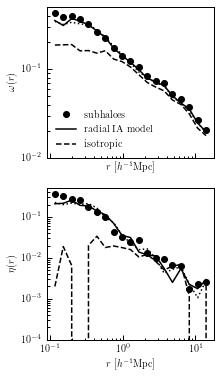

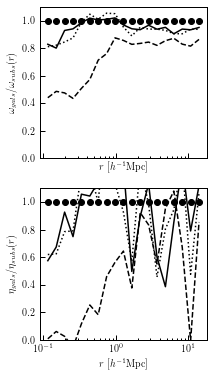

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(3.3,6.6))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

ax = ax1
l0, = ax.plot(rbin_centers, omega_0, 'o', color='black')
l1, = ax.plot(rbin_centers, omega_1, '-', color='black')
l2, = ax.plot(rbin_centers, omega_2, '--', color='black')
l3, = ax.plot(rbin_centers, omega_3, ':', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\omega(r)$')
ax.set_ylim([0.01,0.5])
ax.legend([l0,l1,l2,l3],['subhaloes','radial IA model','isotropic'], frameon=False)

ax = ax2
l0, = ax.plot(rbin_centers, eta_0, 'o', color='black')
l1, = ax.plot(rbin_centers, eta_1, '-', color='black')
l2, = ax.plot(rbin_centers, eta_2, '--', color='black')
l3, = ax.plot(rbin_centers, eta_3, ':', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\eta(r)$')
ax.set_ylim([0.0001,0.5])

plt.show()
fig.savefig('/Users/duncan/Desktop/anisotropy_effect_ee_ed.pdf', dpi=300)

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(3.3,6.6))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)

ax = ax1
l0, = ax.plot(rbin_centers, omega_0/omega_0, 'o', color='black')
l0, = ax.plot(rbin_centers, omega_1/omega_0, '-', color='black')
l0, = ax.plot(rbin_centers, omega_2/omega_0, '--', color='black')
l0, = ax.plot(rbin_centers, omega_3/omega_0, ':', color='black')
ax.set_xscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\omega_{gals}/\omega_{subs}(r)$')
ax.set_ylim([0.0,1.1])

ax = ax2
l0, = ax.plot(rbin_centers, eta_0/eta_0, 'o', color='black')
l0, = ax.plot(rbin_centers, eta_1/eta_0, '-', color='black')
l0, = ax.plot(rbin_centers, eta_2/eta_0, '--', color='black')
l0, = ax.plot(rbin_centers, eta_3/eta_0, ':', color='black')
ax.set_xscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\eta_{gals}/\eta_{subs}(r)$')
ax.set_ylim([0.,1.1])

plt.show()

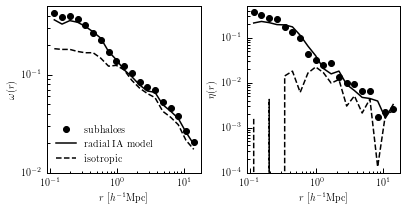

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(7.0,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9, wspace=0.3)

ax = ax1
l0, = ax.plot(rbin_centers, omega_0, 'o', color='black')
l1, = ax.plot(rbin_centers, omega_1, '-', color='black')
l2, = ax.plot(rbin_centers, omega_2, '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\omega(r)$')
ax.set_ylim([0.01,0.5])
ax.legend([l0,l1,l2],['subhaloes','radial IA model','isotropic'], frameon=False)

ax = ax2
l0, = ax.plot(rbin_centers, eta_0, 'o', color='black')
l1, = ax.plot(rbin_centers, eta_1, '-', color='black')
l2, = ax.plot(rbin_centers, eta_2, '--', color='black')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\eta(r)$')
ax.set_ylim([0.0001,0.5])

plt.show()

fig.savefig(figure_path + 'anisotropy_effect_ee_ed.pdf', dpi=300)

## Triaxial NFW

In [16]:
from intrinsic_alignments.ia_models.occupation_models import TriaxialNFW

# add estimate of minor axis
from rotations.vector_utilities import normalized_vectors
B = np.vstack((halocat.halo_table['halo_axisA_x'],
               halocat.halo_table['halo_axisA_y'],
               halocat.halo_table['halo_axisA_z'])).T
A = np.vstack((halocat.halo_table['halo_jx'],
               halocat.halo_table['halo_jy'],
               halocat.halo_table['halo_jz'])).T
B = normalized_vectors(B)
A = normalized_vectors(A)

D = np.cross(A, B)
C = np.cross(B, D)

halocat.halo_table['halo_axisC_x'] = C[:,0]
halocat.halo_table['halo_axisC_y'] = C[:,1]
halocat.halo_table['halo_axisC_z'] = C[:,2]

# define subhalo positions
satellite_position_model_4 = TriaxialNFW(anisotropy_bias=0.0, Lbox=halocat.Lbox)

table_4 = Table(np.copy(halocat.halo_table))
table_4 = satellite_position_model_4.assign_gal_type(table=table_4)
table_4 = satellite_position_model_4.assign_positions(table=table_4)

# define subhalo and host halo alignments
satellite_alignment_model = RadialSatelliteAlignment(satellite_alignment_strength=0.85, Lbox=halocat.Lbox)
central_alignment_model = CentralAlignment(central_alignment_strength=0.99)

table_4 = central_alignment_model.assign_central_orientation(table=table_4)
table_4 = satellite_alignment_model.assign_satellite_orientation(table=table_4)

In [17]:
# examine galaxy-galaxy correlation function
from halotools.mock_observables import tpcf

rbins = np.logspace(-1,1.2,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

mask_4 = (table_4['halo_mpeak']>10**12.5)

coords_4 = np.vstack((table_4['x'],table_4['y'],table_4['z'])).T
result_4 = tpcf(coords_4[mask_4], rbins=rbins, period=halocat.Lbox, num_threads=4)


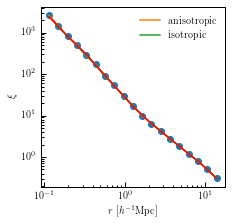

In [18]:
fig = plt.figure(figsize=(3.3,3.3))
l1, = plt.plot(rbin_centers, result_0, 'o')
l1, = plt.plot(rbin_centers, result_1)
l2, = plt.plot(rbin_centers, result_2)
l3, = plt.plot(rbin_centers, result_4, '-', color='red')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}{\rm Mpc}]$')
plt.ylabel(r'$\xi$')
plt.legend([l1,l2],['anisotropic','isotropic'], loc='upper right', frameon=False)
plt.show()

In [19]:
orientations_4 = np.vstack((table_4['galaxy_axisA_x'],
                            table_4['galaxy_axisA_y'],
                            table_4['galaxy_axisA_z'])).T

In [20]:
omega_4 = ed_3d(coords_4[mask_4], orientations_4[mask_4],
              coords_4[mask_4],
              rbins, period=halocat.Lbox, num_threads=4)

eta_4 = ee_3d(coords_4[mask_4], orientations_4[mask_4],
              coords_4[mask_4], orientations_4[mask_4],
              rbins, period=halocat.Lbox, num_threads=4)

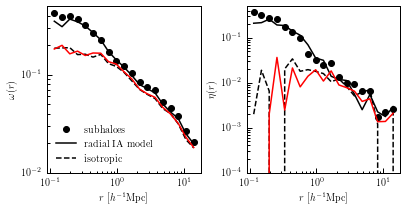

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(7.0,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9, wspace=0.3)

ax = ax1
l0, = ax.plot(rbin_centers, omega_0, 'o', color='black')
l1, = ax.plot(rbin_centers, omega_1, '-', color='black')
l2, = ax.plot(rbin_centers, omega_2, '--', color='black')
l3, = ax.plot(rbin_centers, omega_4, '-', color='red')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\omega(r)$')
ax.set_ylim([0.01,0.5])
ax.legend([l0,l1,l2],['subhaloes','radial IA model','isotropic'], frameon=False)

ax = ax2
l0, = ax.plot(rbin_centers, eta_0, 'o', color='black')
l1, = ax.plot(rbin_centers, eta_1, '-', color='black')
l2, = ax.plot(rbin_centers, eta_2, '--', color='black')
l3, = ax.plot(rbin_centers, eta_4, '-', color='red')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\eta(r)$')
ax.set_ylim([0.0001,0.5])

plt.show()